In [23]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_quantum_stateology_lib as qstates
import b_quantum_geometries_lib as gij
import c_matrix_analysis_lib as matAnsys 
import d_spin_representations_lib as su2
import e_maxent_solver_lib as me

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime

In [67]:
N=4; chain_type = "XY"; k_B = 1; temp = 1e+1; temp_ref = 1e+1

### One body local spin operators
spin_ops_list = su2.one_body_spin_ops(size = N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [-1e-1, -2.5e-1, 0., .5e-1]
H_loc = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False)

### Generating classical observables

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_loc,
                                                op_list = spin_ops_list, centered_x_op = False)

## The Hamiltonian is added a perturbation term 
perturbation_strength = max(Hamiltonian_paras)/2

HH = H_loc + perturbation_strength * cl_ops["x_op"]

In [68]:
# Exact evolution
beta = 1/temp
xmean = 10; nmean = 10; weight_H = 1e2; weight_x = 1e-2; weight_n = 1e-2

K0 = weight_H * beta * HH + weight_x * (cl_ops["x_op"] - xmean)**2 + weight_n * (cl_ops["n_oc_op"] - nmean)**2
rho0 = matAnsys.safe_expm_and_normalize(K = K0, return_free_energy = False)

In [69]:
qutip.expect(rho0, cl_ops["n_oc_op"])

1.7199684793999268

In [70]:
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op_sq"] = cl_ops["p_op"]; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")
subset_of_observables["p_op"] = cl_ops["p_op"]; subset_label_ops.append("p_op")

In [71]:
ts = np.linspace(1e-1, 4., 500)
exact_ev = qutip.mesolve(H = HH,
                         rho0 = rho0,
                         tlist = ts,
                         e_ops = subset_of_observables
                         )

In [72]:
def fetch_kubo_scalar_product(sigma: Qobj, threshold=0.99999):
    evals_evecs = sorted(zip(*sigma.eigenstates()), key=lambda x: -x[0])
    w = 0
    for i, val_vec in enumerate(evals_evecs):
        w += val_vec[0]
        if w > threshold:
            evals_evecs = evals_evecs[: i + 1]
            break

    stored = {}
        
    def ksp(op1, op2):
        if False:
            key = (id(op2), id(op1))
            if key in stored:
                return stored[key]
            key = (id(op1), id(op2))
            if key in stored:
                return stored[key]

        result = sum(
        (
            np.conj((v2.dag() * op1 * v1).tr())
            * ((v2.dag() * op2 * v1).tr())
            * (p1 if p1 == p2 else (p1 - p2) / np.log(p1 / p2))
        )
        for p1, v1 in evals_evecs
        for p2, v2 in evals_evecs
        if (p1 > 0 and p2 > 0)
        )
        
        #    stored[key] = result
        return result

    return ksp

def fetch_kubo_int_scalar_product(sigma: Qobj):
    evals, evecs = sigma.eigenstates()

    def return_func(op1, op2):
        return 0.01 * sum(
            (
                np.conj((v2.dag() * op1 * v1).tr())
                * ((v2.dag() * op2 * v1).tr())
                * ((p1) ** (1.0 - tau))
                * ((p1) ** (tau))
            )
            for p1, v1 in zip(evals, evecs)
            for p2, v2 in zip(evals, evecs)
            for tau in np.linspace(0.0, 1.0, 100)
            if (p1 > 0.0 and p2 > 0.0)
        )

    return return_func

    return lambda op1, op2: 0.01 * sum(
        (
            np.conj((v2.dag() * op1 * v1).tr())
            * ((v2.dag() * op2 * v1).tr())
            * p1 ** (1 - tau)
            * p1 ** (tau)
        )
        for p1, v1 in zip(evals, evecs)
        for p2, v2 in zip(evals, evecs)
        for tau in np.linspace(0, 1, 100)
    )


def fetch_corr_scalar_product(sigma: Qobj):
    return lambda op1, op2: 0.5 * (sigma * (op1.dag() * op2 +
                                            op2 * op1.dag())).tr()

In [73]:
def gram_matrix(basis: list, sp: Callable):
    size = len(basis)
    result = np.zeros([size, size], dtype=float)

    for i, op1 in enumerate(basis):
        for j, op2 in enumerate(basis):
            if j < i:
                continue
            entry = np.real(sp(op1, op2))
            if i == j:
                result[i, i] = entry
            else:
                result[i, j] = result[j, i] = entry

    return result.round(14)


def orthogonalize_basis(basis: list, sp: Callable, idop: Qobj = None):
    if idop:
        idnorm_sq = sp(idop, idop)
        id_comp = [sp(idop, op) / idnorm_sq for op in basis]
        basis = ([idop * idnorm_sq**-0.5] +
                 [op - la for la, op in zip(id_comp, basis)])

    gs = gram_matrix(basis, sp)
    evals, evecs = np.linalg.eigh(gs)
    evecs = [vec / np.linalg.norm(vec) for vec in evecs.transpose()]
    return [
        p ** (-0.5) * sum(c * op for c, op in zip(w, basis))
        for p, w in zip(evals, evecs)
        if p > 0.00001
    ]


def project_op(op: Qobj, orthogonal_basis: list, sp: Callable):
    return np.array([sp(op2, op) for op2 in orthogonal_basis])

def safe_expm_and_normalize(K) -> Qobj:
    n_eig = sum(K.dims[0])
    if n_eig <= 16:
        e0 = max(real(K.eigenenergies()))
    else:
        e0 = max(real(K.eigenenergies(sparse="True", sort="high", eigvals=n_eig)))
    sigma = (K - e0).expm()
    return sigma / sigma.tr()

In [77]:
def fetch_induced_distance(sp):
    def distance(op1, op2):
        dop = op1 - op2
        return np.sqrt(sp(dop, dop))

    return distance

def instantaneous_proj(k, basis, sp, kmb_sp):
    basis = orthogonalize_basis(basis, sp)
    distance = fetch_induced_distance(kmb_sp)
    kp = sum(phi * op for phi, op in zip(project_op(k, basis, sp), basis))
    return distance(kp, k), spectral_norm(k - kp), np.sqrt(kmb_sp(k, k))

def static_proj(k, basis, sp, kmb_sp):
    distance = fetch_induced_distance(kmb_sp)
    kp = sum(phi * op for phi, op in zip(project_op(k, basis, sp), basis))
    return distance(kp, k), spectral_norm(k - kp), np.sqrt(kmb_sp(k, k))

def spectral_norm(op):
    return max(abs(op.eigenenergies()) ** 2) ** 0.5

In [82]:
def projections(Hamiltonian, K0, basis, timespan, depth, beta, HB_B0):
    print("**** Starting Simulation", datetime.now())
    results = {}
    HBasis_local = matAnsys.build_Hierarchical_Basis(Hamiltonian = Hamiltonian,
                                                     seed_operator = HB_B0[-1], 
                                                     depth = depth,
                                                     tol = 1e-5, verbose = False)
    Hierarchical_B = []; del HB_B0[-1]
    Hierarchical_B = HB_B0  + HBasis_local
        
    for b in Hierarchical_B:
        b.__hash__ = lambda slf: hash(id(slf))
        
    res_exact, rhot = me.solve_exact(Hamiltonian = Hamiltonian,
                                     K0 = K0, 
                                     timespan = timespan,
                                     return_evolved_rhos = True,
                                     return_qutip_res_obj = True)
    K_at_timet = res_exact.states
    results["exact"] = K_at_timet
    ts = list(timespan)
    
    print("buildint the instantaneous KMB sp", datetime.now())
    inst_KMB_sp = [fetch_kubo_scalar_product(rho) for rho in rhot]
    print("buildint the instantaneous corr sp", datetime.now())
    inst_corr_sp = [fetch_corr_scalar_product(rho) for rho in rhot]
    
    print("corr", datetime.now())
    
    results["corr"] = []; results["kmb"] = []
    ts_list = list(timespan)
    for t in timespan: 
        ti = ts_list.index(t)
        if ti%10 == 0:
            print("------- Correlation SP proj: step", ti, "at time", datetime.now())
            
        local_value = instantaneous_proj(K_at_timet[ti], Hierarchical_B, inst_corr_sp[ti], inst_KMB_sp[ti])
        results["corr"].append(local_value)
        local_value = 0
        
        if ti%10 == 0:
            print("------- KMB SP proj: step", ti, "at time", datetime.now())
            
        local_value = instantaneous_proj(K_at_timet[ti], Hierarchical_B, inst_KMB_sp[ti], inst_KMB_sp[ti])
        results["kmb"].append(local_value)
        local_value = 0
    
    ts_list = None
    return results

In [ ]:
ts = np.linspace(0, 2.,100)
HB_B0 = [identity_op, H_loc, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"]]
res = projections(Hamiltonian = HH, K0 = K0, basis = HB_B0, timespan  = ts, depth = 4, beta = beta, HB_B0 = HB_B0)

**** Starting Simulation 2023-06-16 11:59:24.469982
buildint the instantaneous KMB sp 2023-06-16 11:59:25.085432
buildint the instantaneous corr sp 2023-06-16 11:59:27.088587
corr 2023-06-16 11:59:27.089609
------- Correlation SP proj: step 0 at time 2023-06-16 11:59:27.089609
------- KMB SP proj: step 0 at time 2023-06-16 11:59:27.752724


In [ ]:
plt.plot(res["corr"][1])

ValueError: x and y must be the same size

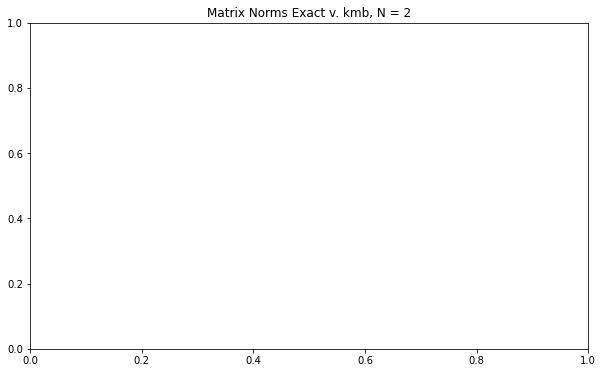

In [49]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Matrix Norms Exact v. kmb, N = 2")
plt.scatter(ts, res["kmb"][0], label = "kmb induced distance")
plt.scatter(ts, res["kmb"][1], label = "Spectral Norm")

ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.show()